In [12]:
import paulssonlab.deaton.trenchripper.trenchripper as trenchripper

In [14]:
import numpy as np
import pandas as pd
import h5py
import scipy.signal
import shutil
import skimage as sk
import os
import pickle
import sys
import h5py_cache
import copy
from parse import compile

from skimage import filters
from paulssonlab.deaton.trenchripper.trenchripper.trcluster import hdf5lock
from paulssonlab.deaton.trenchripper.trenchripper.utils import multifov,pandas_hdf5_handler,writedir
from tifffile import imread

In [189]:
from matplotlib import pyplot as plt

In [190]:
headpath = "/n/scratch2/de64/2019-05-31_validation_data"
nd2file = "/n/scratch2/de64/2019-05-31_validation_data/Main_Experiment.nd2"

In [262]:
class kymograph_cluster:
    def __init__(self,headpath="",trenches_per_file=20,paramfile=False,all_channels=[""],trench_len_y=270,padding_y=20,trench_width_x=30,\
                 t_range=(0,None),invert=False,y_percentile=85,y_min_edge_dist=50,smoothing_kernel_y=(1,9),y_percentile_threshold=0.2,\
                 top_orientation=0,expected_num_rows=None,orientation_on_fail=None,x_percentile=85,background_kernel_x=(1,21),\
                 smoothing_kernel_x=(1,9),otsu_nbins=50,otsu_scaling=1.,trench_present_thr=0.):

        if paramfile:
            parampath = headpath + "/kymograph.par"
            with open(parampath, 'rb') as infile:
                param_dict = pickle.load(infile)

            all_channels = param_dict["All Channels"]
            trench_len_y = param_dict["Trench Length"]
            padding_y = param_dict["Y Padding"]
            trench_width_x = param_dict["Trench Width"]
            t_range = param_dict["Time Range"]
            invert = param_dict["Invert"]
            y_percentile = param_dict["Y Percentile"]
            y_min_edge_dist = param_dict["Minimum Trench Length"]
            smoothing_kernel_y = (1,param_dict["Y Smoothing Kernel"])
            y_percentile_threshold = param_dict['Y Percentile Threshold']
            top_orientation = param_dict["Orientation Detection Method"]
            expected_num_rows = param_dict["Expected Number of Rows (Manual Orientation Detection)"]
            orientation_on_fail = param_dict["Top Orientation when Row Drifts Out (Manual Orientation Detection)"]
            x_percentile = param_dict["X Percentile"]
            background_kernel_x = (1,param_dict["X Background Kernel"])
            smoothing_kernel_x = (1,param_dict["X Smoothing Kernel"])
            otsu_nbins = param_dict["Otsu Threshold Bins"]
            otsu_scaling = param_dict["Otsu Threshold Scaling"]
            trench_present_thr =  param_dict["Trench Presence Threshold"]

        self.headpath = headpath
        self.kymographpath = self.headpath + "/kymograph"
        self.hdf5path = self.headpath + "/hdf5"
        self.all_channels = all_channels
        self.seg_channel = self.all_channels[0]
        self.metapath = self.headpath + "/metadata.hdf5"
        self.meta_handle = pandas_hdf5_handler(self.metapath)
        self.trenches_per_file = trenches_per_file

        self.t_range = t_range
        self.invert = invert

        #### important paramaters to set
        self.trench_len_y = trench_len_y
        self.padding_y = padding_y
        ttl_len_y = trench_len_y+padding_y
        self.ttl_len_y = ttl_len_y
        self.trench_width_x = trench_width_x

        #### params for y
        ## parameter for reducing signal to one dim
        self.y_percentile = y_percentile
        self.y_min_edge_dist = y_min_edge_dist
        ## parameters for threshold finding
        self.smoothing_kernel_y = smoothing_kernel_y
        self.y_percentile_threshold = y_percentile_threshold
        ###
        self.top_orientation = top_orientation
        self.expected_num_rows = expected_num_rows
        self.orientation_on_fail = orientation_on_fail
        #### params for x
        ## parameter for reducing signal to one dim
        self.x_percentile = x_percentile
        ## parameters for midpoint finding
        self.background_kernel_x = background_kernel_x
        self.smoothing_kernel_x = smoothing_kernel_x
        ## parameters for threshold finding
        self.otsu_nbins = otsu_nbins
        self.otsu_scaling = otsu_scaling
        ## New
        self.trench_present_thr = trench_present_thr

        self.output_chunk_shape = (1,1,self.ttl_len_y,(self.trench_width_x//2)*2)
        self.output_chunk_bytes = (2*np.multiply.accumulate(np.array(self.output_chunk_shape))[-1])
        self.output_chunk_cache_mem_size = 2*self.output_chunk_bytes

        self.kymograph_params = {"trench_len_y":trench_len_y,"padding_y":padding_y,"ttl_len_y":ttl_len_y,\
                                 "trench_width_x":trench_width_x,"y_percentile":y_percentile,"invert":invert,\
                             "y_min_edge_dist":y_min_edge_dist,"smoothing_kernel_y":smoothing_kernel_y,\
                                 "y_percentile_threshold":y_percentile_threshold,\
                                 "top_orientation":top_orientation,"expected_num_rows":expected_num_rows,\
                                 "orientation_on_fail":orientation_on_fail,"x_percentile":x_percentile,\
                                 "background_kernel_x":background_kernel_x,"smoothing_kernel_x":smoothing_kernel_x,\
                                "otsu_nbins":otsu_nbins,"otsu_scaling":otsu_scaling,"trench_present_thr":trench_present_thr}

    def median_filter_2d(self,array,smoothing_kernel):
        """Two-dimensional median filter, with average smoothing at the signal
        edges in the second dimension (the non-time dimension).
        Args:
            array_list (list): List containing a single array of 2 dimensional signal to be smoothed.
            smoothing_kernel (tuple): A tuple of ints specifying the kernel under which
            the median will be taken.
        Returns:
            array: Median-filtered 2 dimensional signal.
        """
        kernel = np.array(smoothing_kernel) #1,9
        kernel_pad = kernel//2 + 1 #1,5
        med_filter = scipy.signal.medfilt(array,kernel_size=kernel)
        start_edge = np.mean(med_filter[:,kernel_pad[1]:kernel[1]])
        end_edge = np.mean(med_filter[:,-kernel[1]:-kernel_pad[1]])
        med_filter[:,:kernel_pad[1]] = start_edge
        med_filter[:,-kernel_pad[1]:] = end_edge
        return med_filter

    def get_smoothed_y_percentiles(self,file_idx,y_percentile,smoothing_kernel_y):
        """For each imported array, computes the percentile along the x-axis of
        the segmentation channel, generating a (y,t) array. Then performs
        median filtering of this array for smoothing.
        Args:
            imported_hdf5_handle (h5py.File): Hdf5 file handle corresponding to the input hdf5 dataset
            "data" of shape (channel,y,x,t).
            y_percentile (int): Percentile to apply along the x-axis.
            smoothing_kernel_y (tuple): Kernel to use for median filtering.
        Returns:
            h5py.File: Hdf5 file handle corresponding to the output hdf5 dataset "data", a smoothed
            percentile array of shape (y,t).
        """
        with h5py_cache.File(self.hdf5path+"/hdf5_"+str(file_idx)+".hdf5","r",chunk_cache_mem_size=self.metadata["chunk_cache_mem_size"]) as imported_hdf5_handle:
            img_arr = imported_hdf5_handle[self.seg_channel][:] #t x y
            if self.invert:
                img_arr = sk.util.invert(img_arr)
            perc_arr = np.percentile(img_arr,y_percentile,axis=2,interpolation='lower')
            y_percentiles_smoothed = self.median_filter_2d(perc_arr,smoothing_kernel_y)

            min_qth_percentile = y_percentiles_smoothed.min(axis=1)[:, np.newaxis]
            max_qth_percentile = y_percentiles_smoothed.max(axis=1)[:, np.newaxis]
            y_percentiles_smoothed = (y_percentiles_smoothed - min_qth_percentile)/(max_qth_percentile - min_qth_percentile)

        return y_percentiles_smoothed

    def get_edges_from_mask(self,mask):
        """Finds edges from a boolean mask of shape (t,y). Filters out rows of
        length smaller than y_min_edge_dist.
        Args:
            mask (array): Boolean of shape (y,t) resulting from triangle thresholding.
            y_min_edge_dist (int): Minimum row length necessary for detection.
        Returns:
            list: List containing arrays of edges for each timepoint, filtered for rows that are too small.
        """
        edges_list = []
        start_above_list = []
        end_above_list = []
        for t in range(mask.shape[0]):
            edge_mask = (mask[t,1:] != mask[t,:-1])
            start_above,end_above = (mask[t,0]==True,mask[t,-1]==True)
            edges = np.where(edge_mask)[0]
            edges_list.append(edges)
            start_above_list.append(start_above)
            end_above_list.append(end_above)
        return edges_list,start_above_list,end_above_list

    def get_trench_edges_y(self,y_percentiles_smoothed_array,y_percentile_threshold,y_min_edge_dist):
        """Detects edges in the shape (t,y) smoothed percentile arrays for each
        input array.
        Args:
            y_percentiles_smoothed_array (array): A shape (y,t) smoothed percentile array.
            triangle_nbins (int): Number of bins to be used to construct the thresholding histogram.
            triangle_scaling (float): Factor by which to scale the threshold.
            y_min_edge_dist (int): Minimum row length necessary for detection.
        Returns:
            list: List containing arrays of edges for each timepoint, filtered for rows that are too small.
        """

        trench_mask_y = y_percentiles_smoothed_array>y_percentile_threshold
        edges_list,start_above_list,end_above_list = self.get_edges_from_mask(trench_mask_y)
        return edges_list,start_above_list,end_above_list

    def repair_out_of_frame(self,trench_edges_y,start_above,end_above):
        if start_above:
            trench_edges_y =  np.array([0] + trench_edges_y.tolist())
        if end_above:
            trench_edges_y = np.array(trench_edges_y.tolist() + [int(self.metadata['height'])])
        return trench_edges_y

    def remove_small_rows(self,edges,min_edge_dist):
        """Filters out small rows when performing automated row detection.
        Args:
            edges (array): Array of edges along y-axis.
            min_edge_dist (int): Minimum row length necessary for detection.
        Returns:
            array: Array of edges, filtered for rows that are too small.
        """
        grouped_edges = edges.reshape(-1,2)
        row_lens = np.diff(grouped_edges,axis=1)
        row_mask = (row_lens>min_edge_dist).flatten()
        filtered_edges = grouped_edges[row_mask]
        return filtered_edges.flatten()

    def remove_out_of_frame(self,orientations,repaired_trench_edges_y,start_above,end_above):
        """Takes an array of trench row edges and removes the first/last edge,
        if that edge does not have a proper partner (i.e. trench row mask takes
        value True at boundaries of image).
        Args:
            edges (array): Array of edges along y-axis.
            start_above (bool): True if the trench row mask takes value True at the
            starting edge of the mask.
            end_above (bool): True if the trench row mask takes value True at the
            ending edge of the mask.
        Returns:
            array: Array of edges along y-axis, corrected for edge pairs that
            are out of frame.
        """
        drop_first_row,drop_last_row = (False,False)
        if start_above and orientations[0] == 0: #if the top is facing down and is cut
            drop_first_row = True
            orientations = orientations[1:]
            repaired_trench_edges_y = repaired_trench_edges_y[2:]
        if end_above and orientations[-1] == 1: #if the bottom is facing up and is cut
            drop_last_row = True
            orientations = orientations[:-1]
            repaired_trench_edges_y = repaired_trench_edges_y[:-2]
        return orientations,drop_first_row,drop_last_row,repaired_trench_edges_y

    def get_manual_orientations(self,trench_edges_y_list,start_above_list,end_above_list,expected_num_rows,top_orientation,orientation_on_fail,y_min_edge_dist):
        trench_edges_y = trench_edges_y_list[0]
        start_above = start_above_list[0]
        end_above = end_above_list[0]
        orientations = []

        repaired_trench_edges_y = self.repair_out_of_frame(trench_edges_y,start_above,end_above)
        repaired_trench_edges_y = self.remove_small_rows(repaired_trench_edges_y,y_min_edge_dist)

        if repaired_trench_edges_y.shape[0]//2 == expected_num_rows:
            orientation = top_orientation
            for row in range(repaired_trench_edges_y.shape[0]//2):
                orientations.append(orientation)
                orientation = (orientation+1)%2
            orientations,drop_first_row,drop_last_row,repaired_trench_edges_y = self.remove_out_of_frame(orientations,repaired_trench_edges_y,start_above,end_above)

        elif (repaired_trench_edges_y.shape[0]//2 < expected_num_rows) and orientation_on_fail is not None:
            orientation = orientation_on_fail
            for row in range(repaired_trench_edges_y.shape[0]//2):
                orientations.append(orientation)
                orientation = (orientation+1)%2
            orientations,drop_first_row,drop_last_row,repaired_trench_edges_y = self.remove_out_of_frame(orientations,repaired_trench_edges_y,start_above,end_above)
        else:
            print("Start frame does not have expected number of rows!")

        return orientations,drop_first_row,drop_last_row



    def get_trench_ends(self,trench_edges_y_list,start_above_list,end_above_list,orientations,drop_first_row,drop_last_row,y_min_edge_dist):
        top_orientation = orientations[0]

        y_ends_list = []

        for t,trench_edges_y in enumerate(trench_edges_y_list):
            start_above = start_above_list[t]
            end_above = end_above_list[t]

            repaired_trench_edges_y = self.repair_out_of_frame(trench_edges_y,start_above,end_above)
            repaired_trench_edges_y = self.remove_small_rows(repaired_trench_edges_y,y_min_edge_dist)

            if (repaired_trench_edges_y.shape[0]//2 > len(orientations)) and drop_first_row:
                repaired_trench_edges_y = repaired_trench_edges_y[2:]
            if (repaired_trench_edges_y.shape[0]//2 > len(orientations)) and drop_last_row:
                repaired_trench_edges_y = repaired_trench_edges_y[:-2]
            grouped_edges = repaired_trench_edges_y.reshape(-1,2) # or,2
            y_ends = []
            for edges,orientation in enumerate(orientations):
                y_ends.append(grouped_edges[edges,orientation])
            y_ends = np.array(y_ends)
            y_ends_list.append(y_ends)
        return y_ends_list




    def get_y_drift(self,y_ends_list):
        """Given a list of midpoints, computes the average drift in y for every
        timepoint.
        Args:
            y_midpoints_list (list): A list containing, for each fov, a list of the form [time_list,[midpoint_array]]
            containing the trench row midpoints.
        Returns:
            list: A nested list of the form [time_list,[y_drift_int]] for fov i.
        """
        y_drift = []
        for t in range(len(y_ends_list)-1):
            diff_mat = np.subtract.outer(y_ends_list[t+1],y_ends_list[t])
            if len(diff_mat) > 0:
                min_dist_idx = np.argmin(abs(diff_mat),axis=0)
                min_dists = []
                for row in range(diff_mat.shape[0]):
                    min_dists.append(diff_mat[row,min_dist_idx[row]])
                min_dists = np.array(min_dists)
                median_translation = np.median(min_dists)
            else:
                median_translation = 0
            y_drift.append(median_translation)
        net_y_drift = np.append(np.array([0]),np.add.accumulate(y_drift)).astype(int)
        return net_y_drift

    def keep_in_frame_kernels(self,y_ends_list,y_drift,orientations,padding_y,trench_len_y):
        """Removes those kernels which drift out of the image during any timepoint.
        Args:
            trench_edges_y_lists (list): A list containing, for each fov, a time-ordered list of trench edge arrays.
            y_drift_list (list): A list containing, for each fov, a nested list of the form [time_list,[y_drift_int]].
            imported_array_list (int): A numpy array containing the hdf5 file image data.
            padding_y (int): Y-dimensional padding for cropping.
        Returns:
            list: Time-ordered list of trench edge arrays, filtered for images which
            stay in frame for all timepoints, for fov i.
        """

        init_y_ends = y_ends_list[0]
        max_y_dim = self.metadata['height']
        max_drift,min_drift = np.max(y_drift),np.min(y_drift)

        valid_y_ends_list = []
        valid_orientations = []
        for j,orientation in enumerate(orientations):
            y_end = init_y_ends[j]
            if orientation == 0:
                bottom_edge = y_end+trench_len_y+max_drift
                top_edge = y_end-padding_y+min_drift
                edge_under_max = bottom_edge<max_y_dim
                edge_over_min = top_edge >= 0
            else:
                bottom_edge = y_end+padding_y+max_drift
                top_edge = y_end-trench_len_y+min_drift
                edge_under_max = bottom_edge<max_y_dim
                edge_over_min = top_edge >= 0

            edge_in_bounds = edge_under_max*edge_over_min

            if edge_in_bounds:
                valid_y_ends_list.append([y_end[j] for y_end in y_ends_list])
                valid_orientations.append(orientation)

        valid_y_ends = np.array(valid_y_ends_list).T # t,edge

        return valid_y_ends,valid_orientations

    def get_ends_and_orientations(self,fov_idx,edges_futures,expected_num_rows,top_orientation,orientation_on_fail,y_min_edge_dist,padding_y,trench_len_y):

        fovdf = self.meta_handle.read_df("global",read_metadata=False)
        fovdf = fovdf.loc[(slice(None), slice(self.t_range[0],self.t_range[1])),:]
        working_fovdf = fovdf.loc[fov_idx]

        trench_edges_y_list = []
        start_above_list = []
        end_above_list = []

        for j,file_idx in enumerate(working_fovdf["File Index"].unique().tolist()):
            working_filedf = working_fovdf[working_fovdf["File Index"]==file_idx]
            img_indices = working_filedf["Image Index"].unique()
            first_idx,last_idx = (img_indices[0],img_indices[-1])
            trench_edges_y_list += edges_futures[j][0][first_idx:last_idx+1]
            start_above_list += edges_futures[j][1][first_idx:last_idx+1]
            end_above_list += edges_futures[j][2][first_idx:last_idx+1]

        orientations,drop_first_row,drop_last_row = self.get_manual_orientations(trench_edges_y_list,start_above_list,end_above_list,expected_num_rows,top_orientation,orientation_on_fail,y_min_edge_dist)
        y_ends_list = self.get_trench_ends(trench_edges_y_list,start_above_list,end_above_list,orientations,drop_first_row,drop_last_row,y_min_edge_dist)
        y_drift = self.get_y_drift(y_ends_list)
        valid_y_ends,valid_orientations = self.keep_in_frame_kernels(y_ends_list,y_drift,orientations,padding_y,trench_len_y)

        return y_drift,valid_orientations,valid_y_ends

    def crop_y(self,file_idx,drift_orientation_and_initend_future,padding_y,trench_len_y):
        """Performs cropping of the images in the y-dimension.
        Args:
            i (int): Specifies the current fov index.
            trench_edges_y_list (list): List containing, for each fov entry, a list of time-sorted edge arrays.
            row_num_list (list): List containing The number of trench rows detected in each fov.
            imported_array_list (list): A list containing numpy arrays containing the hdf5 file image
            data of shape (channel,y,x,t).
            padding_y (int): Padding to be used when cropping in the y-dimension.
            trench_len_y (int): Length from the end of the tenches to be used when cropping in the
            y-dimension.
            top_orientation (int, optional): The orientation of the top-most row where 0 corresponds to a trench with
            a downward-oriented trench opening and 1 corresponds to a trench with an upward-oriented trench opening.
        Returns:
            array: A y-cropped array of shape (rows,channels,x,y,t).
        """
        fovdf = self.meta_handle.read_df("global",read_metadata=False)
        fovdf = fovdf.loc[(slice(None), slice(self.t_range[0],self.t_range[1])),:]

        filedf = fovdf.reset_index(inplace=False)
        filedf = filedf.set_index(["File Index","Image Index"], drop=True, append=False, inplace=False)
        filedf = filedf.sort_index()
        working_filedf = filedf.loc[file_idx]
        
        timepoint_indices = working_filedf["timepoints"].unique().tolist()
        image_indices = working_filedf.index.get_level_values("Image Index").unique().tolist()
        
        first_idx,last_idx = (timepoint_indices[0]-self.t_range[0],timepoint_indices[-1]-self.t_range[0])  #CHANGED

        y_drift = drift_orientation_and_initend_future[0][first_idx:last_idx+1]
        
        valid_orientations,valid_y_ends = drift_orientation_and_initend_future[1:]

        drift_corrected_edges = np.add.outer(y_drift,valid_y_ends[0])

        channel_arr_list = []
        for c,channel in enumerate(self.all_channels):
            with h5py_cache.File(self.hdf5path+"/hdf5_"+str(file_idx)+".hdf5","r",chunk_cache_mem_size=self.metadata["chunk_cache_mem_size"]) as imported_hdf5_handle:
                img_arr = imported_hdf5_handle[channel][image_indices[0]:image_indices[-1]+1]
            time_list = []
            lane_y_coords_list = []
            for t in range(len(drift_corrected_edges)):
                trench_ends_y = drift_corrected_edges[t]
                row_list = []
                lane_y_coords = []
                for r,orientation in enumerate(valid_orientations):
                    trench_end = trench_ends_y[r]
                    if orientation == 0:
                        upper = max(trench_end-padding_y,0)
                        lower = min(trench_end+trench_len_y,img_arr.shape[1])
                    else:
                        upper = max(trench_end-trench_len_y,0)
                        lower = min(trench_end+padding_y,img_arr.shape[1])
                    lane_y_coords.append(upper)
                    output_array = img_arr[t,upper:lower,:]
                    row_list.append(output_array)
                time_list.append(row_list)
                lane_y_coords_list.append(lane_y_coords)
            cropped_in_y = np.array(time_list) # t x row x y x x
            if len(cropped_in_y.shape) != 4:
                print("Error in crop_y")
                raise
            else:
                channel_arr_list.append(cropped_in_y)
        return channel_arr_list,lane_y_coords_list

    def get_smoothed_x_percentiles(self,file_idx,drift_orientation_and_initend_future,padding_y,trench_len_y,x_percentile,background_kernel_x,smoothing_kernel_x):

        """Summary.
        Args:
            array_tuple (tuple): A singleton tuple containing the y-cropped hdf5 array of shape (rows,x,y,t).
            background_kernel_x (tuple): Two-entry tuple specifying a kernel size for performing background subtraction
            on xt signal when cropping in the x-dimension. Dim_1 (time) should be set to 1.
            smoothing_kernel_x (tuple): Two-entry tuple specifying a kernel size for performing smoothing
            on xt signal when cropping in the x-dimension. Dim_1 (time) should be set to 1.
        Returns:
            array: A smoothed and background subtracted percentile array of shape (rows,x,t)
        """
        channel_arr_list,_ = self.crop_y(file_idx,drift_orientation_and_initend_future,padding_y,trench_len_y)
        cropped_in_y = channel_arr_list[0]
        
        if self.invert:
            cropped_in_y = sk.util.invert(cropped_in_y)
#         cropped_in_y = y_crop_future[0][0] # t x row x y x x     # (24, 1, 330, 2048)

        x_percentiles_smoothed = []
        for row_num in range(cropped_in_y.shape[1]):
            cropped_in_y_seg = cropped_in_y[:,row_num] # t x y x x
            x_percentiles = np.percentile(cropped_in_y_seg,x_percentile,axis=1) # t x x
            x_background_filtered = x_percentiles - self.median_filter_2d(x_percentiles,background_kernel_x)
            x_smooth_filtered = self.median_filter_2d(x_background_filtered,smoothing_kernel_x)
            x_smooth_filtered[x_smooth_filtered<0.] = 0.
            x_percentiles_smoothed.append(x_smooth_filtered)
        x_percentiles_smoothed=np.array(x_percentiles_smoothed) # row x t x x
        return x_percentiles_smoothed

    def get_midpoints_from_mask(self,mask):
        """Using a boolean x mask, computes the positions of trench midpoints.
        Args:
            mask (array): x boolean array, specifying where trenches are present.
        Returns:
            array: array of trench midpoint x positions.
        """
        transitions = mask[:-1].astype(int) - mask[1:].astype(int)

        trans_up = np.where((transitions==-1))[0]
        trans_dn = np.where((transitions==1))[0]

        if len(np.where(trans_dn>trans_up[0])[0])>0:
            first_dn = np.where(trans_dn>trans_up[0])[0][0]
            trans_dn = trans_dn[first_dn:]
            trans_up = trans_up[:len(trans_dn)]
            midpoints = (trans_dn + trans_up)//2
        else:
            midpoints = []
        return midpoints

    def get_x_row_midpoints(self,x_percentiles_t,otsu_nbins,otsu_scaling):
        """Given an array of signal in x, determines the position of trench
        midpoints.
        Args:
            x_percentiles_t (array): array of trench intensities in x, at time t.
            otsu_nbins (int): Number of bins to use when applying Otsu's method to x-dimension signal.
            otsu_scaling (float): Threshold scaling factor for Otsu's method thresholding.
        Returns:
            array: array of trench midpoint x positions.
        """

        otsu_threshold = sk.filters.threshold_otsu(x_percentiles_t[:,np.newaxis],nbins=otsu_nbins)*otsu_scaling

        x_mask = x_percentiles_t>otsu_threshold
        midpoints = self.get_midpoints_from_mask(x_mask)
        return midpoints

    def get_x_midpoints(self,x_percentiles_smoothed,otsu_nbins,otsu_scaling):
        """Given an x percentile array of shape (rows,t,x), determines the
        trench midpoints of each row array at each time t.
        Args:
            x_percentiles_smoothed_array (array): A smoothed and background subtracted percentile array of shape (rows,x,t)
            otsu_nbins (int): Number of bins to use when applying Otsu's method to x-dimension signal.
            otsu_scaling (float): Threshold scaling factor for Otsu's method thresholding.
        Returns:
            list: A nested list of the form [row_list,[time_list,[midpoint_array]]].
        """
        all_midpoints_list = []
        for row in range(x_percentiles_smoothed.shape[0]):
            row_x_percentiles = x_percentiles_smoothed[row]
            all_midpoints = []
            midpoints = self.get_x_row_midpoints(row_x_percentiles[0],otsu_nbins,otsu_scaling)
            if len(midpoints) == 0:
                return None
            all_midpoints.append(midpoints)

            for t in range(1,row_x_percentiles.shape[0]):
                midpoints = self.get_x_row_midpoints(row_x_percentiles[t],otsu_nbins,otsu_scaling)
                if len(midpoints)/(len(all_midpoints[-1])+1) < 0.5:
                    all_midpoints.append(all_midpoints[-1])
                else:
                    all_midpoints.append(midpoints)
            all_midpoints_list.append(all_midpoints)
        return all_midpoints_list

    def compile_midpoint_futures(self,midpoint_futures):
        num_rows = len(midpoint_futures[0])
        all_midpoints_list = []
        for row in range(num_rows):
            row_midpoints_list = []
            for midpoint_future in midpoint_futures:
                row_midpoints_list += midpoint_future[row]
            all_midpoints_list.append(row_midpoints_list)
        return all_midpoints_list

    def get_x_drift(self,midpoint_futures):
        """Given a list of midpoints, computes the average drift in x for every
        timepoint.
        Args:
            all_midpoints_list (list): A nested list of the form [row_list,[time_list,[midpoint_array]]] containing
            the trench midpoints.
        Returns:
            list: A nested list of the form [row_list,[time_list,[x_drift_int]]].
        """
        all_midpoints_list = self.compile_midpoint_futures(midpoint_futures)

        x_drift_list = []
        for all_midpoints in all_midpoints_list:
            x_drift = []
            for t in range(len(all_midpoints)-1):
                diff_mat = np.subtract.outer(all_midpoints[t+1],all_midpoints[t])
                min_dist_idx = np.argmin(abs(diff_mat),axis=0)
                min_dists = diff_mat[min_dist_idx]
                median_translation = int(np.median(min_dists))
                x_drift.append(median_translation)
            net_x_drift = np.append(np.array([0]),np.add.accumulate(x_drift))
            x_drift_list.append(net_x_drift)
        return x_drift_list

    def filter_midpoints(self,all_midpoints,x_drift,trench_width_x,trench_present_thr):

        drift_corrected_midpoints = []
        for t in range(len(x_drift)):
            drift_corrected_t = all_midpoints[t]-x_drift[t]
            drift_corrected_midpoints.append(drift_corrected_t)
        midpoints_up,midpoints_dn = (all_midpoints[0]-trench_width_x//2,\
                                     all_midpoints[0]+trench_width_x//2+1)

        trench_present_t = []
        for t in range(len(drift_corrected_midpoints)):
            above_mask = np.greater.outer(drift_corrected_midpoints[t],midpoints_up)
            below_mask = np.less.outer(drift_corrected_midpoints[t],midpoints_dn)
            in_bound_mask = (above_mask*below_mask)
            trench_present = np.any(in_bound_mask,axis=0)
            trench_present_t.append(trench_present)
        trench_present_t = np.array(trench_present_t)
        trench_present_perc = np.sum(trench_present_t,axis=0)/trench_present_t.shape[0]

        presence_filter_mask = trench_present_perc>=trench_present_thr

        midpoint_seeds = all_midpoints[0][presence_filter_mask]
        return midpoint_seeds

    def get_in_bounds(self,all_midpoints,x_drift,trench_width_x,trench_present_thr):
        """Produces and writes a trench mask of shape (y_dim,t_dim,x_dim). This
        will be used to mask out trenches from the reshaped "cropped_in_y"
        array at a later step.
        Args:
            cropped_in_y (array): A y-cropped hdf5 array of shape (rows,y,x,t) containing y-cropped image data.
            all_midpoints (list): A list containing, for each time t, an array of trench midpoints.
            x_drift (list): A list containing, for each time t, an int corresponding to the drift of the midpoints in x.
            trench_width_x (int): Width to be used when cropping in the x-dimension.
        Returns:
            h5py.File: Hdf5 file handle corresponding to the trench mask hdf5 dataset
            "data" of shape (y_dim,t_dim,x_dim).
            int: Total number of trenches detected in the image.
        """

        midpoint_seeds = self.filter_midpoints(all_midpoints,x_drift,trench_width_x,trench_present_thr)
        corrected_midpoints = x_drift[:,np.newaxis]+midpoint_seeds[np.newaxis,:]

        midpoints_up,midpoints_dn = (corrected_midpoints-trench_width_x//2,\
                                     corrected_midpoints+trench_width_x//2+1)
        stays_in_frame = np.all(midpoints_up>=0,axis=0)*np.all(midpoints_dn<=self.metadata["width"],axis=0) #filters out midpoints that stay in the frame for the whole time...
        no_overlap = np.append(np.array([True]),(corrected_midpoints[0,1:]-corrected_midpoints[0,:-1])>=(trench_width_x+1)) #corrects for overlap
        if np.sum(no_overlap)/len(no_overlap)<0.9:
            print("Trench overlap issue!!!")

        valid_mask = stays_in_frame*no_overlap
        in_bounds = np.array([midpoints_up[:,valid_mask],\
                            midpoints_dn[:,valid_mask]])
        k_tot = in_bounds.shape[2]

        x_coords = in_bounds[0].T
        return in_bounds,x_coords,k_tot

    def get_all_in_bounds(self,midpoint_futures,x_drift_future,trench_width_x,trench_present_thr):
        """Generates complete kymograph arrays for all trenches in the fov in
        every channel listed in 'self.all_channels'. Writes hdf5 files
        containing datasets of shape (trench_num,y_dim,x_dim,t_dim) for each
        row,channel combination. Dataset keys follow the convention.
        ["[row_number]/[channel_name]"].
        Args:
            cropped_in_y_handle (h5py.File): Hdf5 file handle corresponding to the y-cropped hdf5 dataset
            "data" of shape (rows,channels,x,y,t).
            all_midpoints_list (list): A nested list of the form [row_list,[time_list,[midpoint_array]]] containing
            the trench midpoints.
            x_drift_list (list): A nested list of the form [row_list,[time_list,[x_drift_int]]] containing the computed
            drift in the x dimension.
            trench_width_x (int): Width to be used when cropping in the x-dimension.
        """
        all_midpoints_list = self.compile_midpoint_futures(midpoint_futures)

        in_bounds_list = []
        x_coords_list = []
        k_tot_list = []

        for row_num,all_midpoints in enumerate(all_midpoints_list):
            x_drift = x_drift_future[row_num]
            in_bounds,x_coords,k_tot = self.get_in_bounds(all_midpoints,x_drift,trench_width_x,trench_present_thr)

            in_bounds_list.append(in_bounds)
            x_coords_list.append(x_coords)
            k_tot_list.append(k_tot)

        return in_bounds_list,x_coords_list,k_tot_list

    def init_counting_arr(self,x_dim):
        """Initializes a counting array of shape (x_dim,) which counts from 0
        to x_dim on axis 0.
        Args:
            x_dim (int): Size of x axis to use.
        Returns:
            array: Counting array to be used for masking out trenches in x.
        """
        ones_arr = np.ones(x_dim)
        counting_arr = np.add.accumulate(np.ones(x_dim)).astype(int) - 1
        return counting_arr

    def get_trench_mask(self,in_bounds,counting_arr):
        """Produce a trench mask of shape (y_dim,t_dim,x_dim) which will
        correspond to the reshaped "cropped_in_y" array that will be made
        later.
        Args:
            array_tuple (tuple): Singleton tuple containing the trench boundary array of shape
            (2,t_dim,num_trenches)
            cropped_in_y (array): A y-cropped hdf5 array of shape (rows,y,x,t) containing y-cropped image data.
            counting_arr (array): Counting array to be used for masking out trenches in x, of shape (x_dim,).
        Returns:
            array: A trench mask of shape (y_dim,t_dim,x_dim).
        """
        counting_arr_repeated = np.repeat(counting_arr[:,np.newaxis],in_bounds.shape[1],axis=1)
        masks = []
        print(in_bounds.shape)
        for k in range(in_bounds.shape[2]):
            mask = np.logical_and(counting_arr_repeated>in_bounds[0,:,k],counting_arr_repeated<in_bounds[1,:,k]).T
            masks.append(mask)
        all_mask = np.any(np.array(masks),axis=0)
        k_mask = np.repeat(all_mask[np.newaxis,:,:],self.ttl_len_y,axis=0)
        return k_mask

    def apply_kymo_mask(self,k_mask,img_arr,k_tot):
        """Given a y-cropped image and a boolean trench mask of shape
        (y_dim,t_dim,x_dim), masks that image to generate an output kymograph
        of shape (trench_num,y_dim,x_dim,t_dim). Masked trenches must be a
        fized size, so this only detects trenches that are totally in frame for
        the whole timelapse.
        Args:
            array_tuple (tuple): Tuple containing the y-cropped hdf5 array of shape (t,y,x), and
            the boolean trench mask of shape (y_dim,t_dim,x_dim).
            row_num (int): Int specifying the current row.
            k_tot (int): Int specifying the total number of detected trenches in the fov.
        Returns:
            array: Kymograph array of shape (trench_num,y_dim,x_dim,t_dim).
        """

        img_arr_swap = np.moveaxis(img_arr,(0,1,2),(1,0,2))
        cropped_img_arr = img_arr_swap[k_mask]
        cropped_img_arr = cropped_img_arr.reshape(img_arr_swap.shape[0],img_arr_swap.shape[1],-1)
        cropped_img_arr = np.moveaxis(cropped_img_arr,(0,1,2),(1,0,2)) # t x y x x
        kymo_out = np.stack(np.split(cropped_img_arr,k_tot,axis=2),axis=0) # k x t x y x x
        return kymo_out

    def crop_with_k_masks(self,output_kymograph,cropped_in_y_list,kymo_mask,k_tot,row_num):
        """Generates and writes kymographs of a single row from the already
        y-cropped image data, using a pregenerated kymograph mask of shape
        (y_dim,t_dim,x_dim).
        Args:
            cropped_in_y_handle (h5py.File): Hdf5 file handle corresponding to the y-cropped hdf5 dataset
            "data" of shape (rows,channels,x,y,t).
            k_mask_handle (h5py.File): Hdf5 file handle corresponding to the trench mask hdf5 dataset
            "data" of shape (y_dim,t_dim,x_dim).
            row_num (int): The row number to crop kymographs from.
            k_tot (int): Int specifying the total number of detected trenches in the fov.
        """

        for c,channel in enumerate(self.all_channels):
            dataset_name = str(row_num) + "/" + str(channel)
            cropped_in_y = cropped_in_y_list[c][:,row_num]
            kymo_out = self.apply_kymo_mask(kymo_mask,cropped_in_y,k_tot) # k x t x y x x
            
            

            hdf5_dataset = output_kymograph.create_dataset(dataset_name,data=kymo_out,chunks=self.output_chunk_shape, dtype='uint16')

    def crop_x(self,file_idx,drift_orientation_and_initend_future,in_bounds_future,padding_y,trench_len_y):
        """Generates complete kymograph arrays for all trenches in the fov in
        every channel listed in 'self.all_channels'. Writes hdf5 files
        containing datasets of shape (trench_num,y_dim,x_dim,t_dim) for each
        row,channel combination. Dataset keys follow the convention.
        ["[row_number]/[channel_name]"].
        Args:
            cropped_in_y_handle (h5py.File): Hdf5 file handle corresponding to the y-cropped hdf5 dataset
            "data" of shape (rows,channels,x,y,t).
            all_midpoints_list (list): A nested list of the form [row_list,[time_list,[midpoint_array]]] containing
            the trench midpoints.
            x_drift_list (list): A nested list of the form [row_list,[time_list,[x_drift_int]]] containing the computed
            drift in the x dimension.
            trench_width_x (int): Width to be used when cropping in the x-dimension.
        """
        fovdf = self.meta_handle.read_df("global",read_metadata=False)
        fovdf = fovdf.loc[(slice(None), slice(self.t_range[0],self.t_range[1])),:]
        filedf = fovdf.reset_index(inplace=False)
        filedf = filedf.set_index(["File Index","Image Index"], drop=True, append=False, inplace=False)
        filedf = filedf.sort_index()
        working_filedf = filedf.loc[file_idx]

        timepoint_indices = working_filedf["timepoints"].unique().tolist()
        image_indices = working_filedf.index.get_level_values("Image Index").unique().tolist()
        first_idx,last_idx = (timepoint_indices[0]-self.t_range[0],timepoint_indices[-1]-self.t_range[0])  #CHANGED

        channel_arr_list,lane_y_coords_list = self.crop_y(file_idx,drift_orientation_and_initend_future,padding_y,trench_len_y)
        num_rows = channel_arr_list[0].shape[1]

        in_bounds_list,x_coords_list,k_tot_list = in_bounds_future
        counting_arr = self.init_counting_arr(self.metadata["width"])

        with h5py_cache.File(self.kymographpath+"/kymograph_processed_"+str(file_idx)+".hdf5","w",chunk_cache_mem_size=self.output_chunk_cache_mem_size) as output_kymograph:
            for row_num in range(num_rows):
                in_bounds,k_tot = (in_bounds_list[row_num],k_tot_list[row_num])
                kymo_mask = self.get_trench_mask(in_bounds[:,first_idx:last_idx+1],counting_arr)

                self.crop_with_k_masks(output_kymograph,channel_arr_list,kymo_mask,k_tot,row_num)

        return lane_y_coords_list

    def save_coords(self,fov_idx,x_crop_futures,in_bounds_future,drift_orientation_and_initend_future):
        fovdf = self.meta_handle.read_df("global",read_metadata=False)
        fovdf = fovdf.loc[(slice(None), slice(self.t_range[0],self.t_range[1])),:]
        fovdf = fovdf.loc[fov_idx]

        x_coords_list = in_bounds_future[1]
        orientations = drift_orientation_and_initend_future[1]

        y_coords_list = []
        for j,file_idx in enumerate(fovdf["File Index"].unique().tolist()):
            working_filedf = fovdf[fovdf["File Index"]==file_idx]
            img_indices = working_filedf["Image Index"].unique()
#             first_idx,last_idx = (img_indices[0],img_indices[-1])  CHANGE
            
#             [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
#  28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
# 46
# [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
# 21
            y_coords_list += x_crop_futures[j] # CHANGE
#             y_coords_list += x_crop_futures[j][first_idx:last_idx+1] # t x row list  # CHANGE

        pixel_microns = self.metadata['pixel_microns']
        y_coords = np.array(y_coords_list) # t x row array
        scaled_y_coords = y_coords*pixel_microns
        t_len = scaled_y_coords.shape[0]
        fs = np.repeat([fov_idx],t_len)
        orit_dict = {0:"top",1:"bottom"}
        tpts = np.array(range(t_len))

        missing_metadata = ('x' not in fovdf.columns)

        if not missing_metadata:
            global_x,global_y,ts,file_indices,img_indices = (fovdf["x"].values,fovdf["y"].values,fovdf["t"].values,fovdf["File Index"].values,fovdf["Image Index"].values)
        else:
            file_indices,img_indices = (fovdf["File Index"].values,fovdf["Image Index"].values)

        pd_output = []

        for l,x_coord in enumerate(x_coords_list):
            scaled_x_coord = x_coord*pixel_microns
            yt = scaled_y_coords[:,l]
            orit = np.repeat([orit_dict[orientations[l]]],t_len)
            if not missing_metadata:
                global_yt = yt+global_y
            ls = np.repeat([l],t_len)
            for k in range(scaled_x_coord.shape[0]):
                xt = scaled_x_coord[k]
                if not missing_metadata:
                    global_xt = xt+global_x
                ks = np.repeat([k],t_len)
                if not missing_metadata:
                    pd_output.append(np.array([fs,ls,ks,tpts,file_indices,img_indices,ts,orit,yt,xt,global_yt,global_xt]).T)
                else:
                    pd_output.append(np.array([fs,ls,ks,tpts,file_indices,img_indices,orit,yt,xt]).T)

        pd_output = np.concatenate(pd_output,axis=0)
        if not missing_metadata:
            df = pd.DataFrame(pd_output,columns=["fov","row","trench","timepoints","File Index","Image Index","time (s)","lane orientation","y (local)","x (local)","y (global)","x (global)"])
            df = df.astype({"fov":int,"row":int,"trench":int,"timepoints":int,"File Index":int,"Image Index":int,"time (s)":float,"lane orientation":str,"y (local)":float,"x (local)":float,\
                            "y (global)":float,"x (global)":float})
        else:
            df = pd.DataFrame(pd_output,columns=["fov","row","trench","timepoints","File Index","Image Index","lane orientation","y (local)","x (local)"])
            df = df.astype({"fov":int,"row":int,"trench":int,"timepoints":int,"File Index":int,"Image Index":int,"lane orientation":str,"y (local)":float,"x (local)":float,})
        temp_meta_handle = pandas_hdf5_handler(self.kymographpath + "/temp_metadata_" + str(fov_idx) + ".hdf5")
        temp_meta_handle.write_df("temp",df)

    def generate_kymographs(self,dask_controller):
        writedir(self.kymographpath,overwrite=True)

        dask_controller.futures = {}
        fovdf = self.meta_handle.read_df("global",read_metadata=True)
        self.metadata = fovdf.metadata
        fovdf = fovdf.loc[(slice(None), slice(self.t_range[0],self.t_range[1])),:]

        filedf = fovdf.reset_index(inplace=False)
        filedf = filedf.set_index(["File Index","Image Index"], drop=True, append=False, inplace=False)
        filedf = filedf.sort_index()

        file_list = filedf.index.get_level_values("File Index").unique().values
        fov_list = fovdf.index.get_level_values("fov").unique().values
        num_file_jobs = len(file_list)
        num_fov_jobs = len(fov_list)

        ### smoothed y percentiles ###

        for k,file_idx in enumerate(file_list):
            future = dask_controller.daskclient.submit(self.get_smoothed_y_percentiles,file_idx,\
                                        self.y_percentile,self.smoothing_kernel_y,retries=1)
            dask_controller.futures["Smoothed Y Percentiles: " + str(file_idx)] = future

        ### get trench row edges, y midpoints ###

        for k,file_idx in enumerate(file_list):
            smoothed_y_future = dask_controller.futures["Smoothed Y Percentiles: " + str(file_idx)]
            future = dask_controller.daskclient.submit(self.get_trench_edges_y,smoothed_y_future,self.y_percentile_threshold,\
                                                       self.y_min_edge_dist,retries=1)

            dask_controller.futures["Y Trench Edges: " + str(file_idx)] = future

        ### get y drift, orientations, init edges ###

        for k,fov_idx in enumerate(fov_list):
            working_fovdf = fovdf.loc[fov_idx]
            working_files = working_fovdf["File Index"].unique().tolist()
            edges_futures = [dask_controller.futures["Y Trench Edges: " + str(file_idx)] for file_idx in working_files]
            future = dask_controller.daskclient.submit(self.get_ends_and_orientations,fov_idx,edges_futures,self.expected_num_rows,\
                                                       self.top_orientation,self.orientation_on_fail,self.y_min_edge_dist,self.padding_y,self.trench_len_y,retries=1)
            dask_controller.futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)] = future

        ### smoothed x percentiles ###

        for k,file_idx in enumerate(file_list):
            working_filedf = filedf.loc[file_idx]
            fov_idx = working_filedf["fov"].unique().tolist()[0]
            drift_orientation_and_initend_future = dask_controller.futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)]
            future = dask_controller.daskclient.submit(self.get_smoothed_x_percentiles,file_idx,drift_orientation_and_initend_future,\
                                                       self.padding_y,self.trench_len_y,self.x_percentile,self.background_kernel_x,\
                                                       self.smoothing_kernel_x,retries=1)
            dask_controller.futures["Smoothed X Percentiles: " + str(file_idx)] = future

        ### get x midpoints ###

        for k,file_idx in enumerate(file_list):
            smoothed_x_future = dask_controller.futures["Smoothed X Percentiles: " + str(file_idx)]
            future = dask_controller.daskclient.submit(self.get_x_midpoints,smoothed_x_future,\
                                                       self.otsu_nbins,self.otsu_scaling,retries=1)
            dask_controller.futures["X Midpoints: " + str(file_idx)] = future

        ### get x drift ###

        for k,fov_idx in enumerate(fov_list):
            working_fovdf = fovdf.loc[fov_idx]
            working_files = working_fovdf["File Index"].unique().tolist()
            midpoint_futures = [dask_controller.futures["X Midpoints: " + str(file_idx)] for file_idx in working_files]
            future = dask_controller.daskclient.submit(self.get_x_drift,midpoint_futures,retries=1)
            dask_controller.futures["X Drift: " + str(fov_idx)] = future

        ### get kymograph masks ###

        for k,fov_idx in enumerate(fov_list):
            working_fovdf = fovdf.loc[fov_idx]
            working_files = working_fovdf["File Index"].unique().tolist()
            midpoint_futures = [dask_controller.futures["X Midpoints: " + str(file_idx)] for file_idx in working_files]
            x_drift_future = dask_controller.futures["X Drift: " + str(fov_idx)]
            future = dask_controller.daskclient.submit(self.get_all_in_bounds,midpoint_futures,x_drift_future,\
                                                self.trench_width_x,self.trench_present_thr,retries=1)
            dask_controller.futures["X In Bounds: " + str(fov_idx)] = future

        ### crop in x ###


        for k,file_idx in enumerate(file_list):
            working_filedf = filedf.loc[file_idx]
            fov_idx = working_filedf["fov"].unique().tolist()[0]
            drift_orientation_and_initend_future = dask_controller.futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)]
            in_bounds_future = dask_controller.futures["X In Bounds: " + str(fov_idx)]

            future = dask_controller.daskclient.submit(self.crop_x,file_idx,drift_orientation_and_initend_future,in_bounds_future,self.padding_y,self.trench_len_y,retries=0)
            dask_controller.futures["X Crop: " + str(file_idx)] = future

        ### get coords ###

        for k,fov_idx in enumerate(fov_list):
            working_fovdf = fovdf.loc[fov_idx]
            working_files = working_fovdf["File Index"].unique().tolist()
            x_crop_futures = [dask_controller.futures["X Crop: " + str(file_idx)] for file_idx in working_files]
            in_bounds_future = dask_controller.futures["X In Bounds: " + str(fov_idx)]
            drift_orientation_and_initend_future = dask_controller.futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)]

            future = dask_controller.daskclient.submit(self.save_coords,fov_idx,x_crop_futures,in_bounds_future,drift_orientation_and_initend_future,retries=1)#,priority=priority)
            dask_controller.futures["Coords: " + str(fov_idx)] = future

In [263]:
kymoclust.t_range

(4, 71)

In [264]:
kymoclust = kymograph_cluster(
    headpath=headpath, trenches_per_file=25, paramfile=True
)

In [265]:
writedir(kymoclust.kymographpath,overwrite=True)
fovdf = kymoclust.meta_handle.read_df("global",read_metadata=True)
kymoclust.metadata = fovdf.metadata
fovdf = fovdf.loc[(slice(4,4), slice(kymoclust.t_range[0],kymoclust.t_range[1])),:]

/home/de64/paulssonlab/paulssonlab/src/paulssonlab/deaton/trenchripper/trenchripper/utils.py:92: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


In [266]:
filedf = fovdf.reset_index(inplace=False)
filedf = filedf.set_index(["File Index","Image Index"], drop=True, append=False, inplace=False)
filedf = filedf.sort_index()

file_list = filedf.index.get_level_values("File Index").unique().values
fov_list = fovdf.index.get_level_values("fov").unique().values
num_file_jobs = len(file_list)
num_fov_jobs = len(fov_list)

In [267]:
fovdf

t       x       y         z  File Index  \
fov timepoints                                                       
4   4            2894.814311  5252.9 -3658.6  5302.025           8   
    5            3615.019223  5253.0 -3658.7  5301.950           8   
    6            4334.782007  5253.1 -3658.5  5301.800           8   
    7            5055.034799  5253.2 -3658.5  5301.875           8   
    8            5775.000719  5253.2 -3658.6  5301.675           8   
...                      ...     ...     ...       ...         ...   
    66          47536.010135  5253.7 -3658.6  5301.250           9   
    67          48255.817151  5253.5 -3658.6  5301.125           9   
    68          48976.048295  5253.5 -3658.6  5301.075           9   
    69          49695.680183  5253.5 -3658.5  5301.000           9   
    70          50416.044311  5253.6 -3658.6  5301.125           9   

                Image Index  
fov timepoints               
4   4                     4  
    5                     5  
    6                     6  
    7                     7  
    8                     8  
...                     ...  
    66                   16  
    67                   17  
    68                   18  
    69                   19  
    70                   20  

[67 rows x 6 columns]

In [268]:
fov_list

array([4])

In [269]:
futures = {}
### smoothed y percentiles ###

for k,file_idx in enumerate(file_list):
    future = kymoclust.get_smoothed_y_percentiles(file_idx,kymoclust.y_percentile,\
                             kymoclust.smoothing_kernel_y)
    futures["Smoothed Y Percentiles: " + str(file_idx)] = future

### get trench row edges, y midpoints ###

for k,file_idx in enumerate(file_list):
    smoothed_y_future = futures["Smoothed Y Percentiles: " + str(file_idx)]
    
    future = kymoclust.get_trench_edges_y(smoothed_y_future,kymoclust.y_percentile_threshold,\
                                                           kymoclust.y_min_edge_dist)    

    futures["Y Trench Edges: " + str(file_idx)] = future

### get y drift, orientations, init edges ###

for k,fov_idx in enumerate(fov_list):
    working_fovdf = fovdf.loc[fov_idx]
    working_files = working_fovdf["File Index"].unique().tolist()
    edges_futures = [futures["Y Trench Edges: " + str(file_idx)] for file_idx in working_files]
    future = kymoclust.get_ends_and_orientations(fov_idx,edges_futures,kymoclust.expected_num_rows,\
                                               kymoclust.top_orientation,kymoclust.orientation_on_fail,kymoclust.y_min_edge_dist,kymoclust.padding_y,kymoclust.trench_len_y)
    futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)] = future
    
for k,file_idx in enumerate(file_list):
    working_filedf = filedf.loc[file_idx]
    fov_idx = working_filedf["fov"].unique().tolist()[0]
    drift_orientation_and_initend_future = futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)]
    future = kymoclust.get_smoothed_x_percentiles(file_idx,drift_orientation_and_initend_future,\
                                               kymoclust.padding_y,kymoclust.trench_len_y,kymoclust.x_percentile,kymoclust.background_kernel_x,\
                                               kymoclust.smoothing_kernel_x)
    futures["Smoothed X Percentiles: " + str(file_idx)] = future
    
    
### get x midpoints ###

for k,file_idx in enumerate(file_list):
    smoothed_x_future = futures["Smoothed X Percentiles: " + str(file_idx)]
    future = kymoclust.get_x_midpoints(smoothed_x_future,kymoclust.otsu_nbins,kymoclust.otsu_scaling)
    futures["X Midpoints: " + str(file_idx)] = future

### get x drift ###

for k,fov_idx in enumerate(fov_list):
    working_fovdf = fovdf.loc[fov_idx]
    working_files = working_fovdf["File Index"].unique().tolist()
    midpoint_futures = [futures["X Midpoints: " + str(file_idx)] for file_idx in working_files]
    future = kymoclust.get_x_drift(midpoint_futures)
    futures["X Drift: " + str(fov_idx)] = future
    
### get kymograph masks ###

for k,fov_idx in enumerate(fov_list):
    working_fovdf = fovdf.loc[fov_idx]
    working_files = working_fovdf["File Index"].unique().tolist()
    midpoint_futures = [futures["X Midpoints: " + str(file_idx)] for file_idx in working_files]
    x_drift_future = futures["X Drift: " + str(fov_idx)]
    future = kymoclust.get_all_in_bounds(midpoint_futures,x_drift_future,kymoclust.trench_width_x,kymoclust.trench_present_thr)
    futures["X In Bounds: " + str(fov_idx)] = future

### crop in x ###


for k,file_idx in enumerate(file_list):
    working_filedf = filedf.loc[file_idx]
    fov_idx = working_filedf["fov"].unique().tolist()[0]
    drift_orientation_and_initend_future = futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)]
    in_bounds_future = futures["X In Bounds: " + str(fov_idx)]
    future = kymoclust.crop_x(file_idx,drift_orientation_and_initend_future,in_bounds_future,kymoclust.padding_y,kymoclust.trench_len_y)
    futures["X Crop: " + str(file_idx)] = future
    
#         ### get coords ###

for k,fov_idx in enumerate(fov_list):
    working_fovdf = fovdf.loc[fov_idx]
    working_files = working_fovdf["File Index"].unique().tolist()
    x_crop_futures = [futures["X Crop: " + str(file_idx)] for file_idx in working_files]
    in_bounds_future = futures["X In Bounds: " + str(fov_idx)]
    drift_orientation_and_initend_future = futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(fov_idx)]

    future = kymoclust.save_coords(fov_idx,x_crop_futures,in_bounds_future,drift_orientation_and_initend_future)
    futures["Coords: " + str(fov_idx)] = future

50
21
(2, 46, 83)
(2, 46, 83)
(2, 21, 83)
(2, 21, 83)


In [275]:
futures["Coords: " + str(4)]

In [277]:
temp = pandas_hdf5_handler("/n/scratch2/de64/2019-05-31_validation_data/kymograph/temp_metadata_4.hdf5")

In [293]:
temp.read_df("temp")[0:100:8]

,fov,row,trench,timepoints,File Index,Image Index,time (s),lane orientation,y (local),x (local),y (global),x (global)
0,4,0,0,0,8,4,2894.814311,top,56.736652,3.088815,-3601.863348,5255.988815
8,4,0,0,8,8,12,8654.999207,top,56.736652,3.901661,-3601.863348,5257.601661
16,4,0,0,16,8,20,14415.079343,top,56.574083,3.576522,-3602.025917,5256.876522
24,4,0,0,24,8,28,20175.650855,top,56.574083,3.088815,-3602.025917,5255.988815
32,4,0,0,32,8,36,25936.147415,top,56.574083,2.926246,-3602.025917,5255.726246
40,4,0,0,40,8,44,31695.705551,top,56.411514,3.251384,-3602.188486,5256.451384
48,4,0,0,48,9,2,37455.614063,top,56.574083,3.413953,-3602.025917,5256.813953
56,4,0,0,56,9,10,43215.477119,top,56.574083,3.576522,-3602.025917,5256.676522
64,4,0,0,64,9,18,48976.048295,top,56.736652,3.576522,-3601.863348,5257.076522
72,4,0,1,5,8,9,6495.300767,top,56.736652,7.153045,-3601.963348,5260.353045


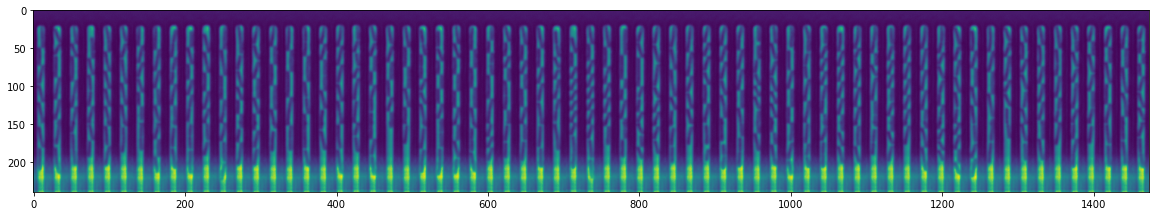

In [294]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = [20, 10]
temp_list = []
with h5py.File("/n/scratch2/de64/2019-05-31_validation_data/kymograph/kymograph_processed_8.hdf5","r") as infile:
    temp_list.append(infile["0/Phase"][41])
with h5py.File("/n/scratch2/de64/2019-05-31_validation_data/kymograph/kymograph_processed_9.hdf5","r") as infile:
    temp_list.append(infile["0/Phase"][41])

kymoboi = trenchripper.utils.kymo_handle()
kymoboi.import_wrap(np.concatenate(temp_list,axis=0))
plt.imshow(kymoboi.return_unwrap())
plt.show()

In [215]:
len(futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(4)][0])

67

In [180]:
futures["Y Trench Drift, Orientations and Initial Trench Ends: " + str(4)][2]

array([[ 369, 1715],
       [ 369, 1715],
       [ 368, 1714],
       [ 369, 1714],
       [ 369, 1715],
       [ 369, 1714],
       [ 370, 1715],
       [ 369, 1715],
       [ 369, 1714],
       [ 369, 1715],
       [ 369, 1714],
       [ 369, 1714],
       [ 369, 1714],
       [ 368, 1714],
       [ 368, 1714],
       [ 368, 1714],
       [ 368, 1714],
       [ 368, 1714],
       [ 368, 1713],
       [ 368, 1713],
       [ 368, 1713],
       [ 368, 1713],
       [ 368, 1714],
       [ 368, 1714],
       [ 368, 1713],
       [ 368, 1713],
       [ 368, 1714],
       [ 368, 1714],
       [ 368, 1713],
       [ 367, 1713],
       [ 368, 1714],
       [ 367, 1713],
       [ 368, 1713],
       [ 368, 1713],
       [ 368, 1713],
       [ 367, 1712],
       [ 367, 1713],
       [ 368, 1714],
       [ 368, 1713],
       [ 368, 1713],
       [ 367, 1713],
       [ 368, 1713],
       [ 367, 1712],
       [ 367, 1713],
       [ 368, 1713],
       [ 367, 1713],
       [ 368, 1713],
       [ 368,

In [61]:
        ### smoothed y percentiles ###

        for k,file_idx in enumerate(file_list):
            future = dask_controller.daskclient.submit(self.get_smoothed_y_percentiles,file_idx,\
                                        self.y_percentile,self.smoothing_kernel_y,retries=1)
            dask_controller.futures["Smoothed Y Percentiles: " + str(file_idx)] = future

        ### get trench row edges, y midpoints ###

        for k,file_idx in enumerate(file_list):
            smoothed_y_future = dask_controller.futures["Smoothed Y Percentiles: " + str(file_idx)]
            future = dask_controller.daskclient.submit(self.get_trench_edges_y,smoothed_y_future,self.y_percentile_threshold,\
                                                       self.y_min_edge_dist,retries=1)

            dask_controller.futures["Y Trench Edges: " + str(file_idx)] = future


NameError: name 'dask_controller' is not defined